# Analysing FIFA 18 Player Database
## -Sankalp Devasthali
Hi all, for the last 12 years or so, I have been addicted to this football/soccer simulation game called "FIFA". I must have had over 3000 hours under my belt and I see no stopping my streak (as my mom and girlfriend surely agree upon). Realizing that my playing disappoints them, I decided to put my addiction to proper use. As a data science major, I decided to analyze (and maybe train models) to prove my worthiness. That's right, I'm doing science!

To start with, I am using the Kaggle FIFA 18 players dataset as listed here - https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib
from skimage import io
import seaborn as sns
from matplotlib import ticker
from math import pi
from skimage.color import rgb2gray
from geopy.geocoders import Nominatim
import cartopy.crs as ccrs

In [3]:
%%time
complete_data = pd.read_csv("FIFA18PlayersDataset.csv",skipinitialspace=True, low_memory = False)

Wall time: 361 ms


Now that I've imported my data (with some cool stats around it), I will "Explore" my data. Come join me in my exciting journey where I shall wander like Dora and also wonder like Dora.

In [4]:
print(complete_data.columns.values)
print(complete_data.describe())

['Unnamed: 0' 'Name' 'Age' 'Photo' 'Nationality' 'Flag' 'Overall'
 'Potential' 'Club' 'Club Logo' 'Value' 'Wage' 'Special' 'Acceleration'
 'Aggression' 'Agility' 'Balance' 'Ball control' 'Composure' 'Crossing'
 'Curve' 'Dribbling' 'Finishing' 'Free kick accuracy' 'GK diving'
 'GK handling' 'GK kicking' 'GK positioning' 'GK reflexes'
 'Heading accuracy' 'Interceptions' 'Jumping' 'Long passing' 'Long shots'
 'Marking' 'Penalties' 'Positioning' 'Reactions' 'Short passing'
 'Shot power' 'Sliding tackle' 'Sprint speed' 'Stamina' 'Standing tackle'
 'Strength' 'Vision' 'Volleys' 'CAM' 'CB' 'CDM' 'CF' 'CM' 'ID' 'LAM' 'LB'
 'LCB' 'LCM' 'LDM' 'LF' 'LM' 'LS' 'LW' 'LWB' 'Preferred Positions' 'RAM'
 'RB' 'RCB' 'RCM' 'RDM' 'RF' 'RM' 'RS' 'RW' 'RWB' 'ST']
         Unnamed: 0           Age       Overall     Potential       Special  \
count  17981.000000  17981.000000  17981.000000  17981.000000  17981.000000   
mean    8990.000000     25.144541     66.247984     71.190813   1594.095100   
std     5190

I have here a list of columns and some quick descriptive stats about the various columns.

I see that my data pertains to players and their individual attributes. Along with name, nationality, and age (not given as DoB, but as a definitive number), I have access to their photographs (online), their clubs, their wages, their preferred positions, their overall ratings, and their various attributes. The attributes are the game's way of quantifying a players abilities and encompass physical, mental, and special capabilities of each of the 17981 players in the list. I assume that these attributes change with time and what I have is just a snapshot.

Interestingly, their in-game potential and their changes in overall ratings for every position are also provided. This makes me wonder that this database is for the "Career Mode" version of the game and not "Kick Off" or "Ultimate Team" mode, which tend to have dynamic ratings and limited effect of the player's overall abilities.

Let us do some more visualizations!

In [5]:
all_positions = ''.join(a for a in complete_data["Preferred Positions"].unique())
all_positions = list(filter(None,set(all_positions.split(' '))))
print(all_positions)

['GK', 'ST', 'CM', 'RW', 'CB', 'RM', 'RB', 'CAM', 'RWB', 'LB', 'LWB', 'CF', 'LM', 'CDM', 'LW']


{'GK': 2029, 'ST': 3219, 'CM': 3589, 'RW': 991, 'CB': 3630, 'RM': 2542, 'RB': 2039, 'CAM': 2281, 'RWB': 189, 'LB': 2051, 'LWB': 188, 'CF': 350, 'LM': 2548, 'CDM': 2663, 'LW': 971}


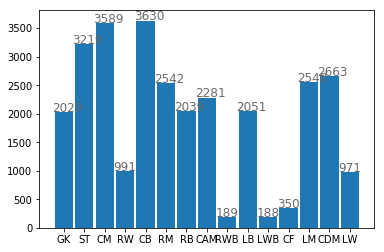

In [6]:
pos_counter = {}
for pos in all_positions:
    for prepos in complete_data["Preferred Positions"]:
        if pos in prepos:
            pos_counter[pos] = pos_counter.get(pos,0)+1
print(pos_counter)
ax = plt.bar(pos_counter.keys(),pos_counter.values(),width=0.9)  
for i in ax.patches:
    plt.text(i.get_x()-0.13,i.get_height()+10,str(i.get_height()), fontsize=12,
                color='dimgrey')
plt.show()

The histogram above shows that of the 17981 players in the database, only around 190 players are adept at playing Left Wing Back (LWB) or Right Wing Back (RWB) positions. Compared to that, there are 12 times more players adept at playing Left Back and Right Back. So, for gamers who prefer the defensive formations 5-x-x-x, there aren't enough great wing backs to choose from.

In [7]:
pd.options.display.float_format = '{:.4f}'.format

def rem_dol_M(data):
    if type(data) is str:
        data = data.strip('€')
        if 'M' in data:
            data = float(data.strip('M'))*1000
            return data
        if "K" in data:
            data = float(data.strip('K'))
            return data
    return float(data)/1000
complete_data['Value'] = complete_data.Value.apply(rem_dol_M)
complete_data['Wage'] = complete_data.Wage.apply(rem_dol_M)

,Value,Wage
count,17981.0000,17981.0000
mean,2385.3896,11.5470
std,5353.9700,23.0800
min,0.0000,0.0000
25%,300.0000,2.0000
50%,675.0000,4.0000
75%,2100.0000,12.0000
max,123000.0000,565.0000


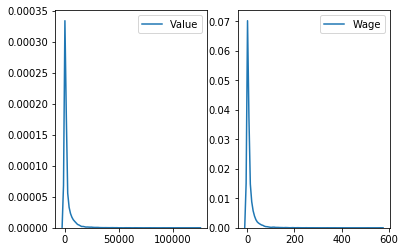

In [8]:
plt.subplot(1,2,1)
sns.kdeplot(complete_data['Value'])
plt.subplot(1,2,2)
sns.kdeplot(complete_data['Wage'])

complete_data[['Value','Wage']].describe()

Above we see the plots for player value and player wage. The graphs suggest that most of the players do not earn those crazy salaries that we hear about. In fact, the top 1% earn more than 2 standard deviations from the mean. The most insight I can derive from this is that players earn on an average of 11,000 Euros per week and that they are paid commensurate to their perceived value.

Now let us see some comparisons of the top 10 players (by Overall rating) on a few key attributes.

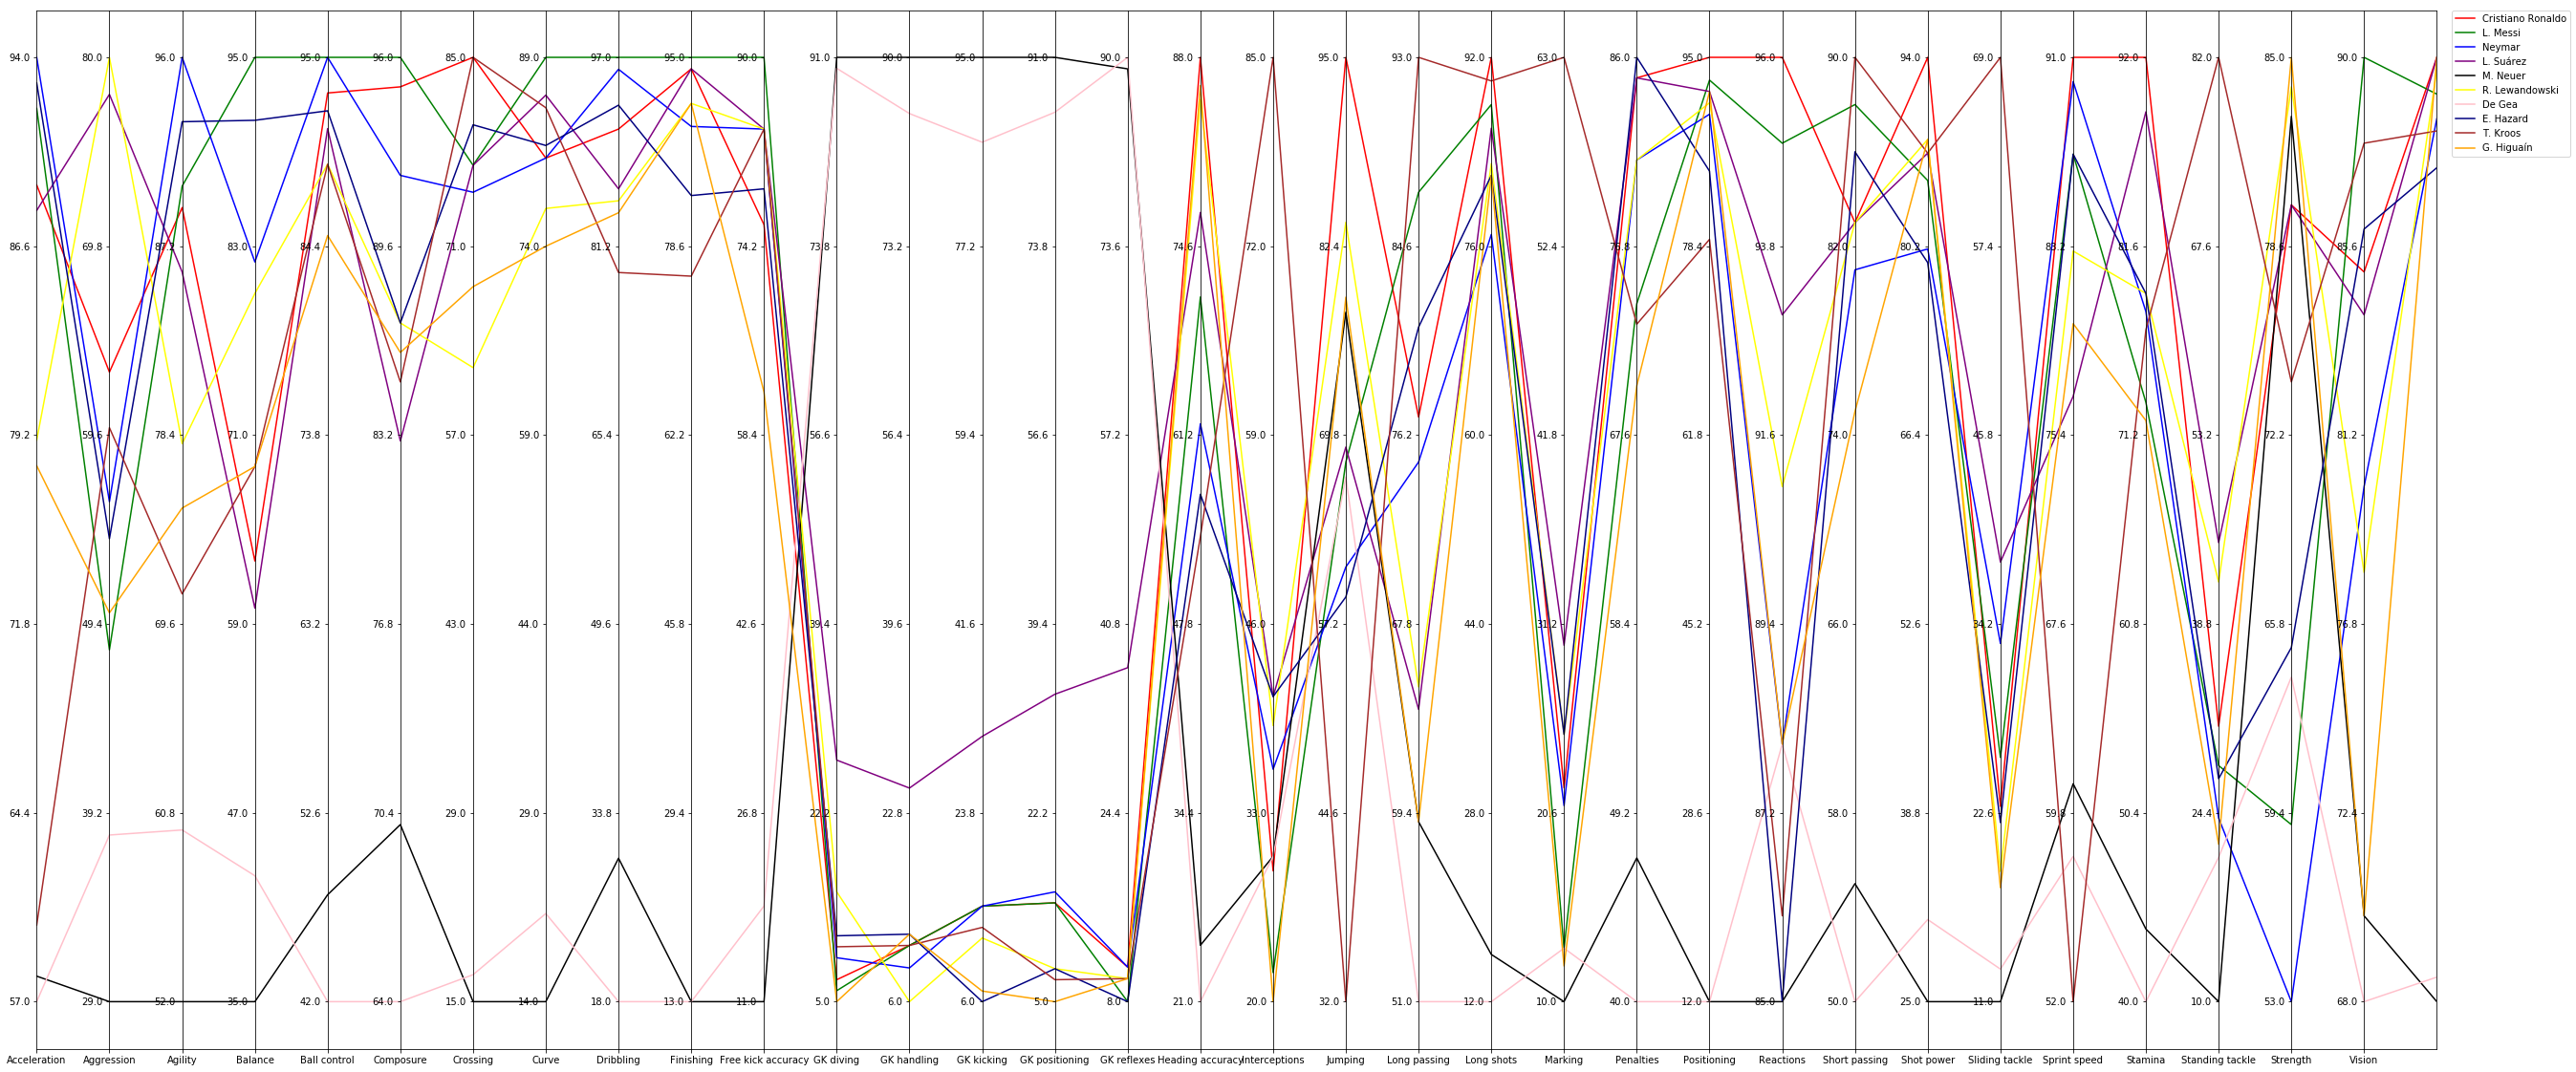

In [11]:
categories = ['Acceleration','Aggression' ,'Agility', 'Balance', 'Ball control',
              'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
              'Free kick accuracy', 'GK diving' ,'GK handling', 'GK kicking','GK positioning',
              'GK reflexes' ,'Heading accuracy', 'Interceptions','Jumping', 'Long passing',
              'Long shots' ,'Marking', 'Penalties','Positioning', 'Reactions',
              'Short passing' ,'Shot power', 'Sliding tackle','Sprint speed', 'Stamina',
              'Standing tackle' ,'Strength', 'Vision', 'Volleys']
x = [i for i,_ in enumerate(categories)]

def convert_to_int(data):
    return int(data)

paraplot = complete_data[:10].copy()

colours = ['#FF0000', '#008000', '#0000FF', '#800080', '#000000', 
           '#FFFF00', '#FFC0CB', '#000080', '#A52A2A', '#FFA500']

colours = {paraplot['Name'].loc[i]: colours[i] for i, _ in enumerate(paraplot['Name'])}

fig, axes = plt.subplots(1,len(x)-1, sharey=False, figsize=(45,20))
min_max_range = dict()
for cats in categories:
    paraplot[cats] = paraplot[cats].apply(convert_to_int)
    min_max_range[cats] = [paraplot[cats].min(),paraplot[cats].max(),paraplot[cats].max()-paraplot[cats].min()]
    paraplot[cats] = np.true_divide(paraplot[cats] - paraplot[cats].min(), paraplot[cats].max()-paraplot[cats].min())
    
for i, ax in enumerate(axes):
    for idx in paraplot.index:
        plot_category = paraplot.loc[idx, 'Name']
        ax.plot(x, paraplot.loc[idx, categories], colours[plot_category])
    ax.set_xlim([x[i], x[i+1]])
    
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[categories[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    norm_min = paraplot[categories[dim]].min()
    norm_range = np.ptp(paraplot[categories[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)
    

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([categories[dim]])
    
plt.subplots_adjust(wspace=0)

plt.legend(
    [plt.Line2D((0,1),(0,0),color=colours[players]) for players in paraplot.Name],
    paraplot.Name,
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

plt.show()

Boy, is that a beautifully complicated and epilepsy inducing graph! Credits go to "http://benalexkeen.com/parallel-coordinates-in-matplotlib/", Ben Keen

We can use this image to compare the likes of Ronaldo and Messi and Neymar and Lewandowski. In fact, check out the how DDG standsup to Neuer for handling and diving. Interestingly, Luis Suarez is the best "keeper" amongst the non-keepers in the top - 10 footballers. No wonder he saved Uruguay's bottoms in 2010 World Cup. 

That being said, let us settle the life long debate of Ronaldo vs Messi in a FIFA 18 manner. The chart below compares the two on the same set of attributes and let us decide who is better.

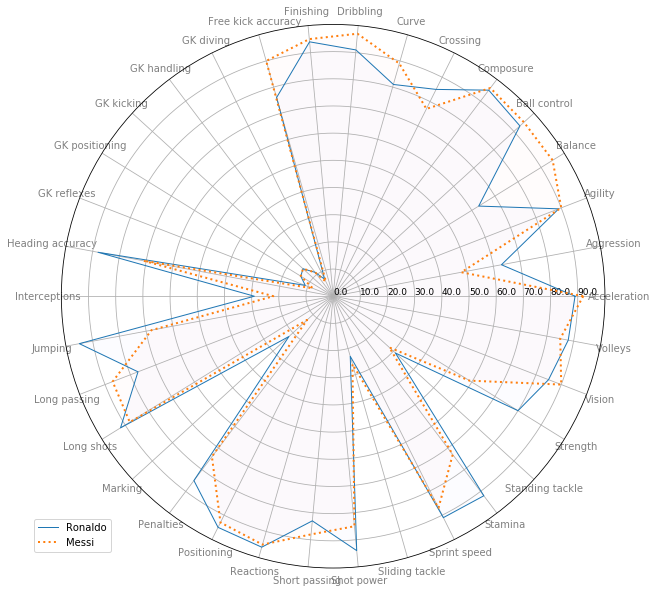

In [12]:
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111, polar = True)
plt.xticks(angles[:-1],categories,color = 'grey', size = 10)
ax.set_rlabel_position(0)
plt.yticks(np.linspace(0,90,10,endpoint=True),np.linspace(0,90,10,endpoint=True), color='black', size= 9)
plt.ylim(0,100)

#Ronaldo
values = complete_data[categories].loc[complete_data["Name"] == "Cristiano Ronaldo"].values.flatten().tolist()
values += values[:1]
values = [int(v) for v in values]
ax.plot(angles, values, linewidth=1, linestyle='solid',label="Ronaldo")
ax.fill(angles, values, 'b', alpha=0.01)

#Messi
values = complete_data[categories].loc[complete_data["Name"] == "L. Messi"].values.flatten().tolist()
values += values[:1]
values = [int(v) for v in values]
ax.plot(angles, values, linewidth=2, linestyle='dotted', label="Messi")
ax.fill(angles, values, 'r', alpha=0.01)

plt.legend(loc='upper right', bbox_to_anchor = (0.1,0.1))

It comes as no surprise that both Ronaldo and Messi have similar characteristics and that the blue and orange areas are practically overlapping.

Ronaldo is faster, has more stamina and strength, can jump better, head the ball well and is a great penalty taker (no surprises there, Penaldo).  
Messi, on the other hand, is a dribbling maestro who has insane balance, great vision, and great passing abilities. He is also a better free-kick taker (Remember Argentina vs Nigeria in 2014?).

The decision has been made!  
Both players are incomparable and have different playing styles.  
If you want a finisher, go with Ronaldo. His attributes are perfect for a winger or a striker. Ronaldo will give you goals.  
If you want to orchestrate a move on the field and finish in style, you want Messi in your team. He can pass, dribble, and score important goals for your team.

Incredibly, these stats are reflective of how both players perform in real life! Their play styles suite their respective teams (Real Madrid, Barcelona) perfectly and that is what makes them lethal against any opposition.



Now enough about players, let us see how many countries provide footballers and where do these countries lie?

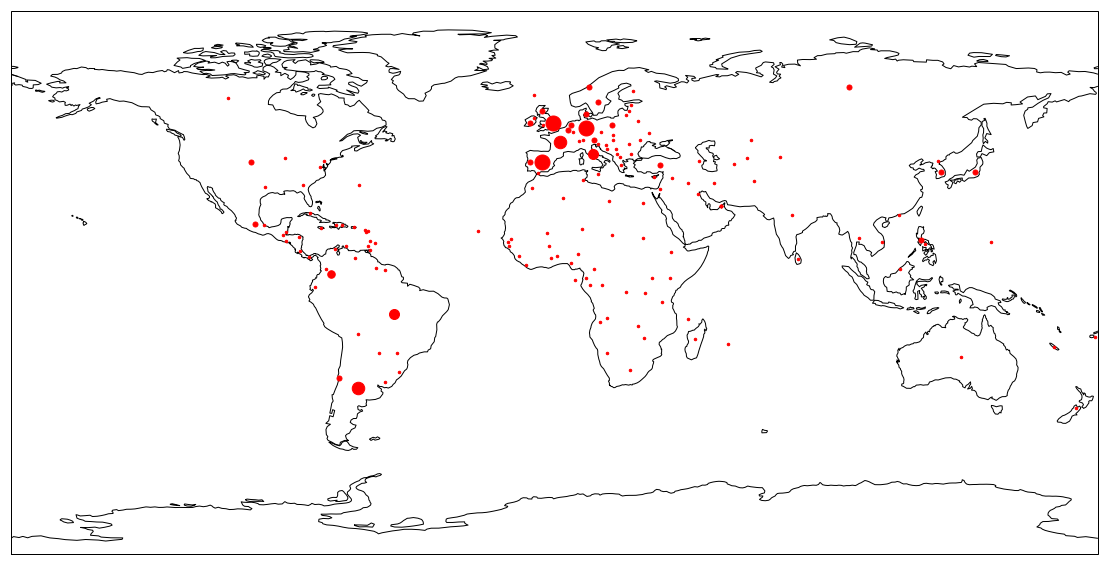

Wall time: 1min 7s


In [14]:
%%time

def get_lon_lat(data):
    geolocator = Nominatim()
    location= geolocator.geocode(data)
    return [location.longitude,location.latitude]

countries = complete_data.Nationality.values.flatten().tolist()
countries = [c.replace('Rep.','Republic') for c in countries]
countries = [c.replace('DPR','Democratic People''s Republic') for c in countries]
countries = [c.replace('FYR','') for c in countries]

countryset = list(sorted(set(countries)))

locdict = {}
for c in countryset:
    try:
        loc = get_lon_lat(c)
        locdict[c] = [0,loc[0],loc[1]]
    except:
        print(c)
        
for c in countries:
    for l in list(locdict.keys()):
        if l in c:
            locdict.get(l)[0] += 1
size = []
for c in locdict.values():
    if c[0] > 1000:
        size.append(15)
    elif c[0] > 850:
        size.append(12.5)
    elif c[0] > 750:
        size.append(10)
    elif c[0] > 500:
        size.append(7.5)
    elif c[0] > 250:
        size.append(5)
    else:
        size.append(2.5)

fig = plt.figure(figsize =(20,10))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
for i, c in enumerate(locdict.values()):
    ax.plot(c[1],c[2], transform=ccrs.PlateCarree() , color = 'red', markersize=size[i], marker= 'o')
plt.show()

Interesting.

Majority of the players belong to Europe, mostly in western Europe, and mostly out of France, England, Germany, Spain, and Italy. The rest of the European nations do supply players but not in a huge quantity. The South American powerhouses (Brazil, Argentina, Colombia, etc) are heavy exporters again and there are also decent amount of South East Asian and Chinese players represented here. 

Funnily enough, African countries, being so many, do not have the depth of squad although they export a decent number of players to the world.

Now let us see which teams have the most players in all major positions (Attack, Midfield, Defence, Keepers).

In [15]:
%%time

Forwards = ['ST','CF','RW','LW']
Midfields = ['LM','CAM','CM','CDM','RM']
Defenders = ['LB','LWB','CB','RWB','RB']

TeamCounts = {}
for t in complete_data["Club"]:
    TeamCounts[t] = [0,0,0,0,0]

for i in range(complete_data.shape[0]):
    counter = 0
    fwdExtraCounter = 0
    midExtraCounter = 0
    defExtraCounter = 0
    ## Forwards
    for pos in Forwards:
        if pos in complete_data["Preferred Positions"].iloc[i]:
            if fwdExtraCounter == 0:
                TeamCounts[complete_data["Club"].iloc[i]][0] += 1
                fwdExtraCounter += 1
                counter += 1
    ## Midfielders
    for pos in Midfields:
        if pos in complete_data["Preferred Positions"].iloc[i]:
            if fwdExtraCounter == 0:
                TeamCounts[complete_data["Club"].iloc[i]][1] += 1
                midExtraCounter += 1
                counter += 1
    ## Defenders
    for pos in Defenders:
        if pos in complete_data["Preferred Positions"].iloc[i]:
            if defExtraCounter == 0:
                TeamCounts[complete_data["Club"].iloc[i]][2] += 1
                defExtraCounter += 1
                counter += 1
    ## Goalkeepers
    if 'GK' in complete_data["Preferred Positions"].iloc[i]:
        TeamCounts[complete_data["Club"].iloc[i]][3] += 1
        counter += 1
    ## Multiple Positions (FWD, MF, Def, GK)
    if counter > 1:
        TeamCounts[complete_data["Club"].iloc[i]][4] += 1
    

Wall time: 4.64 s


In [16]:
TeamCountsList = []
TeamList = []

for key, values in TeamCounts.items():
    TeamCountsList.append(values)
    TeamList.append(key)

TeamCountsList = np.array(TeamCountsList)
TeamList = np.array(TeamList)
  
mostFwds = np.argsort(TeamCountsList[:,0])[::-1]
mostMids = np.argsort(TeamCountsList[:,1])[::-1]
mostDefs = np.argsort(TeamCountsList[:,2])[::-1]
mostGK = np.argsort(TeamCountsList[:,3])[::-1]
mostVersatile = np.argsort(TeamCountsList[:,4])[::-1]
print("Most Forwards\n", TeamList[mostFwds][1:11])
print("Most Midfielders\n", TeamList[mostMids][1:11])
print("Most Defenders\n", TeamList[mostDefs][1:11])
print("Most Goalkeepers\n", TeamList[mostGK][1:11])
print("Most Versatile\n", TeamList[mostVersatile][1:11])

Most Forwards
 ['FC Nordsjælland' 'SG Sonnenhof Großaspach' 'Sogndal' 'Everton' 'Pachuca'
 'Kaizer Chiefs' 'Newport County' 'Sheffield United' 'Reading'
 'Derby County']
Most Midfielders
 ['UD Las Palmas' 'Al Nassr' 'Al Ahli' 'Rosario Central' 'KV Kortrijk'
 'RC Deportivo de La Coruña' 'NAC Breda' 'CF Reus Deportiu'
 'Crystal Palace' 'Oldham Athletic']
Most Defenders
 ['Southampton' 'Portland Timbers' 'Rochdale' 'SV Wehen Wiesbaden'
 'AS Saint-Étienne' 'VfL Wolfsburg' 'FC Luzern' 'Manchester City'
 'Watford' 'Newcastle United']
Most Goalkeepers
 ['Bournemouth' 'Blackpool' 'FC Ural' 'West Bromwich Albion' 'Al Taawoun'
 'SC Heerenveen' 'PSV' 'Ajax' 'Shrewsbury' 'Excelsior']
Most Versatile
 ['UD Las Palmas' 'SK Rapid Wien' 'CA Osasuna' 'CF Reus Deportiu'
 'Seattle Sounders FC' 'Toronto FC' 'RC Deportivo de La Coruña'
 'Columbus Crew SC' 'Crystal Palace' 'FC Luzern']


What do we have here! The teams with most forwards are Nordic and a few English teams. Most of them do not even play in a major league (except Everton). Perhaps # of forwards is not proportional to # of wins.

The most midfielders belong to South American teams with the occasional Saudi offering. Not much for insights here.

The English Premier League seems obsessed with Defenders where 4 of its 20 teams features in the top-10 defender rich teams. Southapton and Manchester city aren't a surprise in this list.

Bournmouth has the most keepers followed by Blackpool and a list of exclusively European clubs. Cool stuff.

Finally, versatility. This list is mostly Norhtern American or Spanish teams with Crystal Palace eeking in into the 9th spot. Sadly, this versatility did not help USA to qualify for the World Cup in 2018.

Finally, let us find the average face (in black and white right now) of the FIFA 18 dataset.
I am scrapping image data from "https://sofifa.org" and doing the image processing required in a function and finally throwing the output. The links of the images are given in the dataframe although they need to be modified to scrap correctly.

In [17]:
images_data = complete_data[["Name","Age","Photo","Nationality"]]
images_data[:10]

,Name,Age,Photo,Nationality
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany
5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain
7,E. Hazard,26,https://cdn.sofifa.org/48/18/players/183277.png,Belgium
8,T. Kroos,27,https://cdn.sofifa.org/48/18/players/182521.png,Germany
9,G. Higuaín,29,https://cdn.sofifa.org/48/18/players/167664.png,Argentina


In [18]:
%%time
# def url2image1(url):
#    resp = urllib.request.urlopen(url)
#    image = np.asarray(bytearray(resp.read()), dtype="uint8")
#    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#    return image

def url2image(url):
    import re
    from skimage.color import rgb2gray
    url = re.sub("/48/","/1x/",url)
    try:
        image = io.imread(url, as_grey=True)
    except:
        #print(url, "none")
        return None
    return image

images_data["Image"] = images_data.Photo.apply(url2image)

Wall time: 14min 51s


E:\Softwares\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# store = pd.HDFStore('store.h5')
# store['data'] = data
# data.to_pickle('FIFA_with_images')

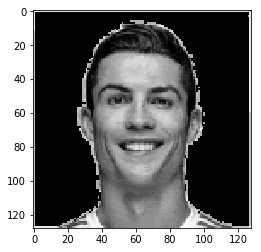

In [19]:
plt.imshow(images_data["Image"][0], cmap="gray")

Ronaldo! Such charisma that lad!

unfortunately, FIFA 18 doesn't have all the player faces, hence I will drop the players whose face isn't listed on the website. Finally, based on the remaining players, I shall find the average face.

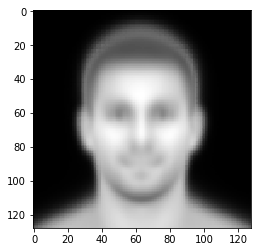

In [20]:
only_images = images_data.dropna()
only_images = only_images["Image"]
only_images = only_images.as_matrix()

images = []
for o in only_images:
    images.append(o.flatten())
images = np.array(images)

avg_image = np.mean(images,axis = 0)
plt.imshow(avg_image.reshape(128,128), cmap="gray")

What do we have here!

The average FIFA 18 player is White in colour with black-ish hair. The player looks more like Messi than Ronaldo (okay?) and has the most symmetric face. I will try to do it in colour whenever I get time but this is what it is as of now.

I hope you enjoyed going through the FIFA 18 database with me. I enjoyed the whole experience of automatically downloading data, scrapping data, plotting data on maps, playing around with Python Dictionaries, some bit of image manipulation, loads of graphs, and Panda'ing around the project.

Feel free to provide suggestion to improve code, improve graphs, do different analysis, and ways to achieve better results. Thank You. 